In [1]:
import numpy as np


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef

from F2O.fwOp.fwOperator import fwOp

from F2O.noise.noiseModels import noiseModels

from F2O.F2O_sptl import gd as GD

import demo.synthData as sd


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

# Simple quadratic optimization problem

### Generate data

In [2]:
N = 2000

synthData = sd.synthData(enableJAX=False)

A, b, xori = synthData.genDataMV(N, 1.*N)

### Define optimization variable

In [3]:
args = F2O.argsF2O()

args.verbose     = True
args.verboseStep = 10
args.fCostClass  = f2oDef.cost.L2_lin      # F(x) = 0.5|| fAx(x) - b ||_2^2, where fAx is lineal


### Select forward operator 

In [4]:
Op       = fwOp()
Op.linOp = f2oDef.fAx.matrixvec
Op.A     = A
  

# Solve $F(\mathbf{x}) = 0.5|| \mbox{Op}(\mathbf{x}) - \mathbf{b} ||_2^2$ via GD 

$$ \large
\begin{array}{l}
\begin{array}{rcl}
\mbox{Init :} & & \mathbf{x}_0  - \mbox{ Initial solution}\\
 & & p_\alpha - \mbox{ Compute step-size (simplest case: } \alpha = \mbox{cte.)}\\
 & \\
\end{array} \\
\mathbf{\mbox{for }} k = 0,1,\ldots \\
 \quad \mathbf{g}_k = \nabla F(\mathbf{x}_k) \\
 \quad \alpha_k = p_\alpha(\cdot) \\
 \quad \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k\cdot \mathbf{g}_k
\end{array} 
$$

Python code (see  ` F2O_sptl.py ` )

```python
for k in range(nIter):   
    
    grad = computeGrad(x, b, None)
    
    gd.RecordStats(k, x, b, grad, gdStats, None, computeCost)   # --- statistics --
                    
    alpha = computeSS(k, grad, x)       # compute step-size
    
    x = x - alpha*grad                  # Gradient descent step
    
    gdStats[k,1] = alpha                # --- record step-Size ---
        
    if stopFunc(k, x, gdStats):         # check for exit condition / print stats
      print('Stop criteria -- iteration {0}'.format(k))
      break
```

### (0) dummy call (for fair time performance comparison)

In [5]:

x = []
Stats = []
solverSS  = []


ssCte = 1.0
nIter = 2

# Comment the next command out to avoid printing the cost function evolution
args.verbose   = False

args.ssPoliciy = f2oDef.ss.Cte
args.ssCte     = ssCte
_, _   = GD(Op, b, nIter, args)


### (1) along with a constant step-size

In [6]:
ssCte = 2.5e-3
nIter = 100

# Comment the next command out to avoid printing the cost function evolution
args.verbose   = True

# ----

args.ssPolicy = f2oDef.ss.Cte
args.ssCte     = ssCte
sol            = GD(Op, b, nIter, args)

x.append( sol[0] )
Stats.append( sol[1] )
solverSS.append( args.ssPolicy.name )



Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 2.50e-03    7.38e-03    nan
 10	 8.865e+02	 2.50e-03    3.84e-02    8.781e-02
 20	 8.054e+02	 2.50e-03    7.12e-02    4.446e-02
 30	 7.344e+02	 2.50e-03    1.09e-01    2.914e-02
 40	 6.722e+02	 2.50e-03    1.37e-01    2.133e-02
 50	 6.173e+02	 2.50e-03    1.65e-01    1.662e-02
 60	 5.689e+02	 2.50e-03    2.38e-01    1.348e-02
 70	 5.259e+02	 2.50e-03    2.81e-01    1.124e-02
 80	 4.877e+02	 2.50e-03    3.06e-01    9.578e-03
 90	 4.536e+02	 2.50e-03    3.35e-01    8.293e-03
 99	 4.259e+02	 2.50e-03    3.63e-01    7.367e-03


### (2) along with the BB (Barzilai-Borwein) step-size

In [7]:

args.ssPolicy = f2oDef.ss.BBv1
args.ssCte     = 0.0
sol            = GD(Op, b, nIter, args)

x.append( sol[0] )
Stats.append( sol[1] )
solverSS.append( args.ssPolicy.name )



Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 3.58e-01    7.93e-03    nan
 10	 2.326e+01	 3.48e-01    7.93e-02    1.102e-01
 20	 5.329e-03	 3.93e+00    1.56e-01    4.322e-03
Stop criteria -- iteration 29


### (3) along with the Cauchy step-size

In [8]:
args.ssPolicy = f2oDef.ss.Cauchy
args.ssCte     = 0.0
sol            = GD(Op, b, nIter, args)

x.append( sol[0] )
Stats.append( sol[1] )
solverSS.append( args.ssPolicy.name )



Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 3.58e-01    1.14e-02    nan
 10	 1.304e+01	 3.88e-01    8.58e-02    3.724e-02
 20	 1.688e+00	 3.89e-01    1.41e-01    1.152e-02
 30	 2.620e-01	 3.89e-01    1.87e-01    4.309e-03
 40	 4.357e-02	 3.89e-01    2.86e-01    1.718e-03
 50	 7.513e-03	 3.88e-01    3.33e-01    7.053e-04
 60	 1.325e-03	 3.88e-01    3.84e-01    2.943e-04
 70	 2.373e-04	 3.88e-01    4.32e-01    1.240e-04
 80	 4.300e-05	 3.88e-01    4.79e-01    5.263e-05
 90	 7.858e-06	 3.88e-01    5.45e-01    2.245e-05
 99	 1.713e-06	 3.99e-01    5.88e-01    1.061e-05


### Plot cost functional evolution vs. iteration

Text(0.5, 1.0, '\n Step-size vs. iteration')

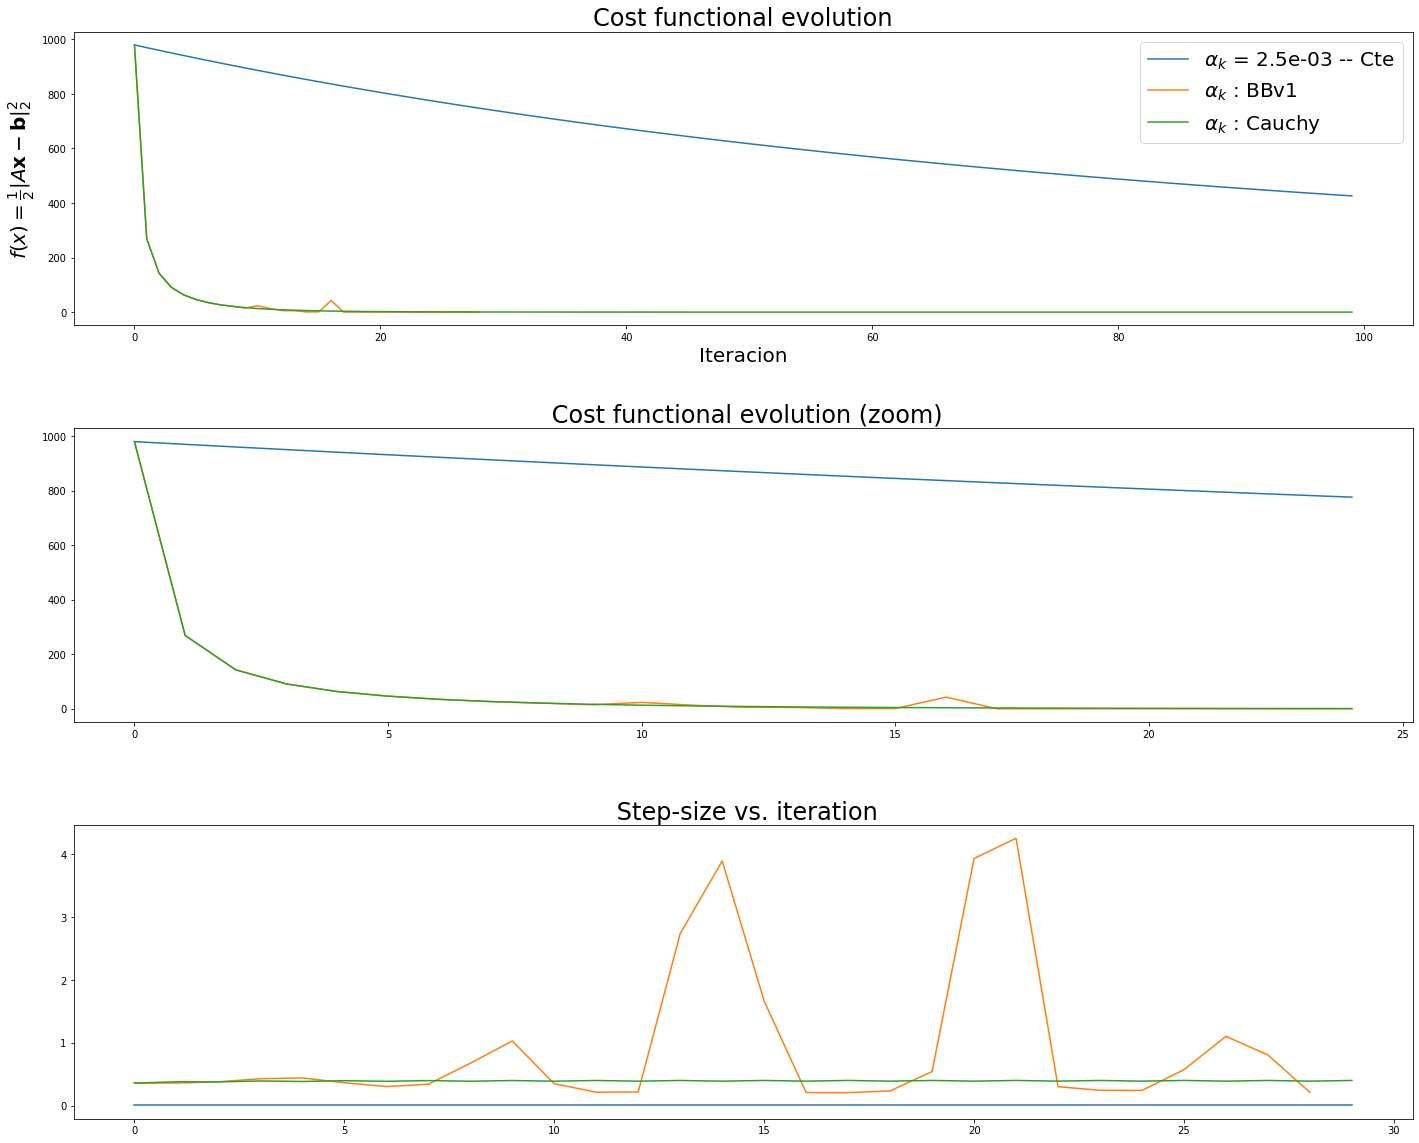

In [9]:
import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator


fig = PLT.figure(figsize=(24, 20))

ax1 = fig.add_subplot(3, 1, 1)

for n in range(len(x)):
    if n == 0:
       PLT.plot(Stats[n][:,0], label=r'$\alpha_k$ = {:1.1e} -- {:}'.format(ssCte, solverSS[n]) )
    else:
       PLT.plot(Stats[n][:,0], label=r'$\alpha_k$ : {:} '.format(solverSS[n]) )
        
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2}\| A \mathbf{x} - \mathbf{b} \|_2^2$',fontsize=20)
PLT.xlabel('Iteracion',fontsize=20)
PLT.title('Cost functional evolution',fontsize=24)
PLT.subplots_adjust(hspace = 0.35)

ax1 = fig.add_subplot(3, 1, 2)
for n in range(len(x)):
    PLT.plot(Stats[n][0:25,0] )
PLT.title('\n Cost functional evolution (zoom)',fontsize=24)


ax1 = fig.add_subplot(3, 1, 3)
for n in range(len(x)):
    PLT.plot(Stats[n][0:30,1] )

PLT.title('\n Step-size vs. iteration',fontsize=24)



### Plot cost functional evolution vs. Time

Text(0.5, 1.0, '\n Cost functional evolution (zoom)')

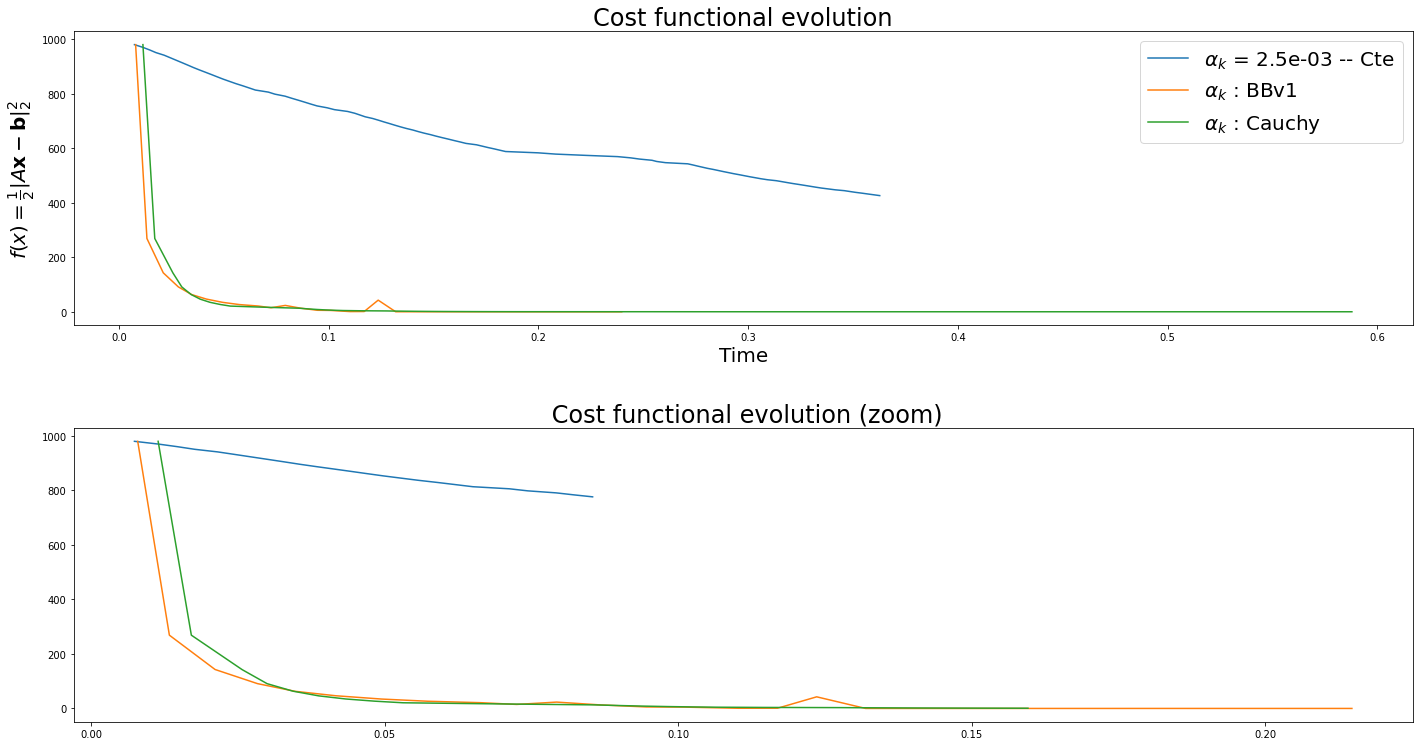

In [10]:

fig = PLT.figure(figsize=(24, 20))

ax1 = fig.add_subplot(3, 1, 1)

for n in range(len(x)):
    if n == 0:
       PLT.plot(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha_k$ = {:1.1e} -- {:}'.format(ssCte, solverSS[n]) )
    else:
       PLT.plot(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha_k$ : {:}'.format(solverSS[n]) )
        
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2}\| A \mathbf{x} - \mathbf{b} \|_2^2$',fontsize=20)
PLT.xlabel('Time',fontsize=20)
PLT.title('Cost functional evolution',fontsize=24)
PLT.subplots_adjust(hspace = 0.35)

ax1 = fig.add_subplot(3, 1, 2)
for n in range(len(x)):
    PLT.plot(Stats[n][0:25,2], Stats[n][0:25,0] )

PLT.title('\n Cost functional evolution (zoom)',fontsize=24)



## Cauchy variants



In [12]:
z = []
Stats = []
ssPol = []


args.ssCte = ssCte

ssPol.append(f2oDef.ss.Cauchy)              # dummy call
ssPol.append(f2oDef.ss.Cauchy)
ssPol.append(f2oDef.ss.CauchyLagged)
ssPol.append(f2oDef.ss.CauchyRand)

args.verboseStep = 20

for k in range(len(ssPol)):
    args.ssPolicy = ssPol[k]
    sol = GD(Op, b, nIter, args)
    z.append(sol[0])
    Stats.append(sol[1])

    



Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 3.58e-01    7.90e-03    nan
 20	 1.688e+00	 3.89e-01    1.52e-01    1.152e-02
 40	 4.357e-02	 3.89e-01    3.25e-01    1.718e-03
 60	 1.325e-03	 3.88e-01    4.32e-01    2.943e-04
 80	 4.300e-05	 3.88e-01    5.62e-01    5.263e-05
 99	 1.713e-06	 3.99e-01    6.55e-01    1.061e-05


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 3.58e-01    4.54e-03    nan
 20	 1.688e+00	 3.89e-01    1.12e-01    1.152e-02
 40	 4.357e-02	 3.89e-01    2.24e-01    1.718e-03
 60	 1.325e-03	 3.88e-01    3.37e-01    2.943e-04
 80	 4.300e-05	 3.88e-01    4.90e-01    5.263e-05
 99	 1.713e-06	 3.99e-01    6.04e-01    1.061e-05


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 3.58e-01    4.46e-03    nan
 20	 6.865e-03	 2.55e-01    1.16e-01    1.292e-03
Stop criteria -- iteration 33


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 3.73e-01    4.55e-03    nan
 20	 1.615e-01	 7.64

Text(0.5, 1.0, '\n Step-size vs. iteration')

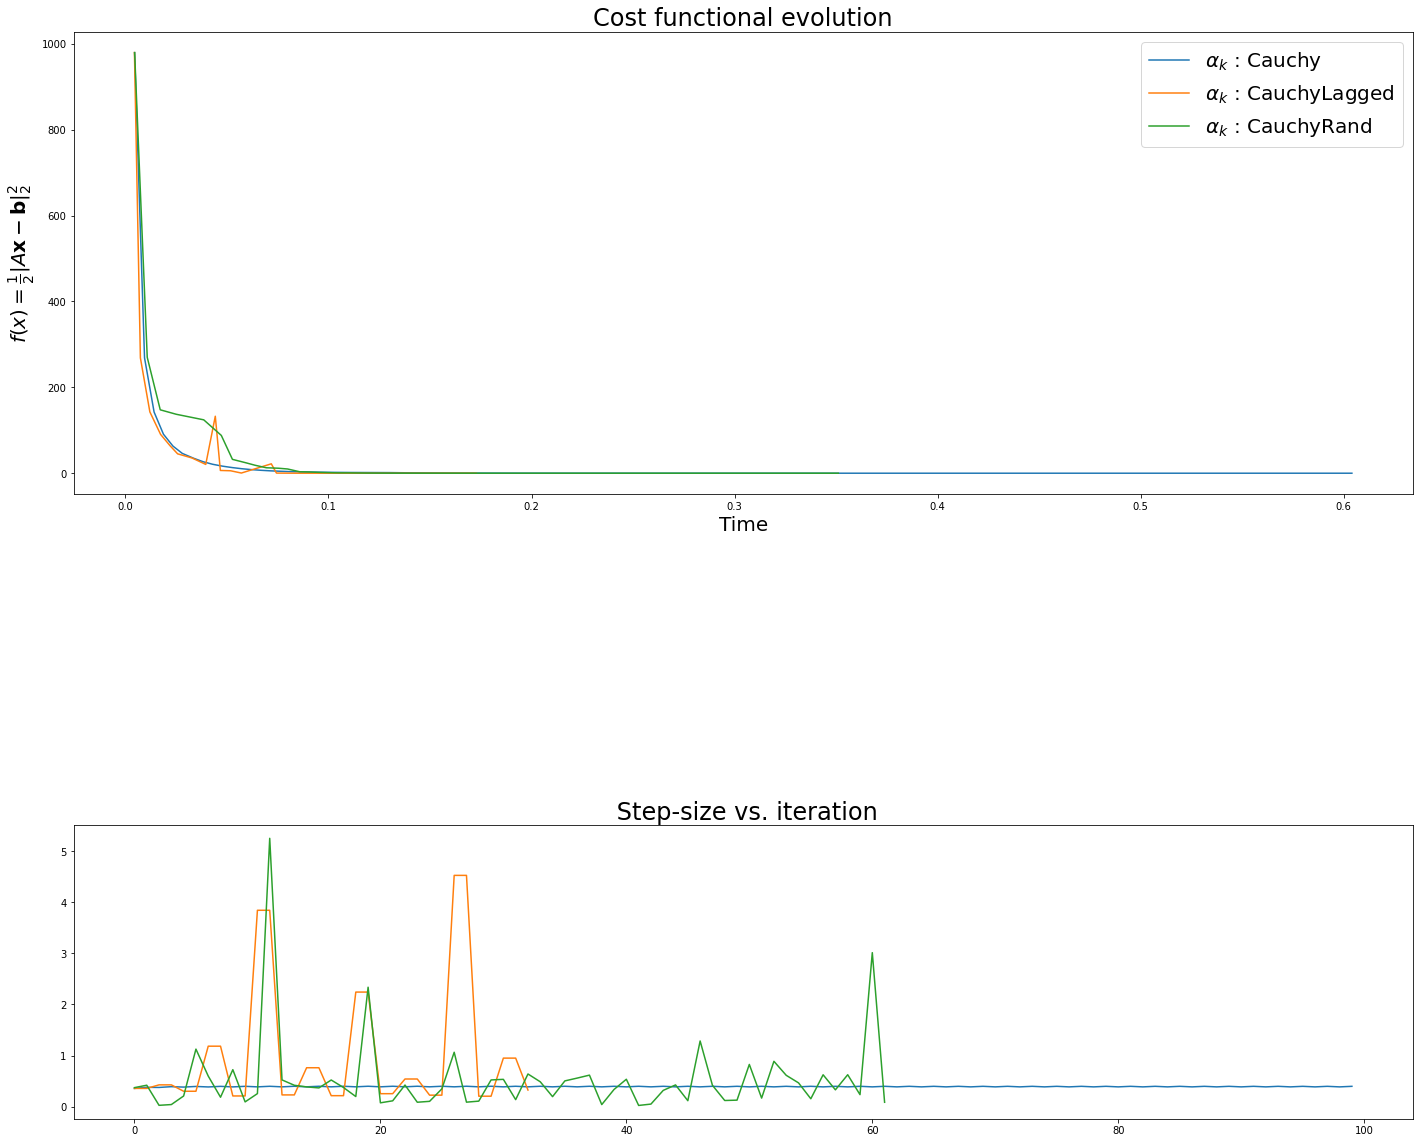

In [15]:
fig = PLT.figure(figsize=(24, 20))

ax1 = fig.add_subplot(2, 1, 1)


for n in np.arange(1,len(ssPol)):
    PLT.plot(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha_k$ : {:}'.format(ssPol[n].name) )

PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2}\| A \mathbf{x} - \mathbf{b} \|_2^2$',fontsize=20)
PLT.xlabel('Time',fontsize=20)
PLT.title('Cost functional evolution',fontsize=24)
PLT.subplots_adjust(hspace = 0.35)


ax1 = fig.add_subplot(3, 1, 3)
for n in np.arange(1,len(ssPol)):
    PLT.plot(Stats[n][:,1], label=r'$\alpha_k$ : {:}'.format(ssPol[n].name) )

PLT.title('\n Step-size vs. iteration',fontsize=24)


## BB variants

* BBv1 
  $\large \qquad \alpha = \frac{\| s_k \|_2^2}{\langle s_k, y_k \rangle}$

* BBv2 
  $\large \qquad \alpha = \frac{\langle s_k, y_k \rangle}{\| y_k \|_2^2}$
 
* BBv3
 $\large \qquad \alpha = \sqrt{ \frac{\| s_k \|_2^2}{\| y_k \|_2^2} }$
 
 
where $\large s_k = x_k - x_{k-1}$ and $\large y_k = \nabla f_k - \nabla f_{k-1}$

In [19]:
z = []
Stats = []
ssPol = []


args.ssCte = ssCte

ssPol.append(f2oDef.ss.BBv1)              # dummy call
ssPol.append(f2oDef.ss.BBv1)
ssPol.append(f2oDef.ss.BBv2)
ssPol.append(f2oDef.ss.BBv3)

for n in range(len(ssPol)):
    args.ssPoliciy = ssPol[n]
    sol = GD(Op, b, nIter, args)
    z.append(sol[0])
    Stats.append(sol[1])

    



Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 1.21e-01    4.90e-03    nan
 20	 1.512e-01	 2.46e-01    1.21e-01    1.894e-03
 40	 1.383e-04	 3.29e-01    2.58e-01    2.717e-04
Stop criteria -- iteration 44


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 6.13e-01    4.68e-03    nan
 20	 2.048e-02	 3.12e-01    1.16e-01    1.427e-03
 40	 7.145e-06	 9.04e-01    2.59e-01    3.939e-05
Stop criteria -- iteration 44


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 4.07e-01    4.53e-03    nan
 20	 2.054e-01	 1.10e+00    1.18e-01    8.600e-03
 40	 8.068e-05	 8.13e-02    2.33e-01    2.966e-05
Stop criteria -- iteration 46


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.795e+02	 2.49e-01    4.57e-03    nan
 20	 4.635e-01	 4.21e-01    1.00e-01    1.763e-02
 40	 1.021e-03	 7.12e+00    2.14e-01    3.451e-03
Stop criteria -- iteration 52


Text(0.5, 1.0, '\n Step-size vs. iteration')

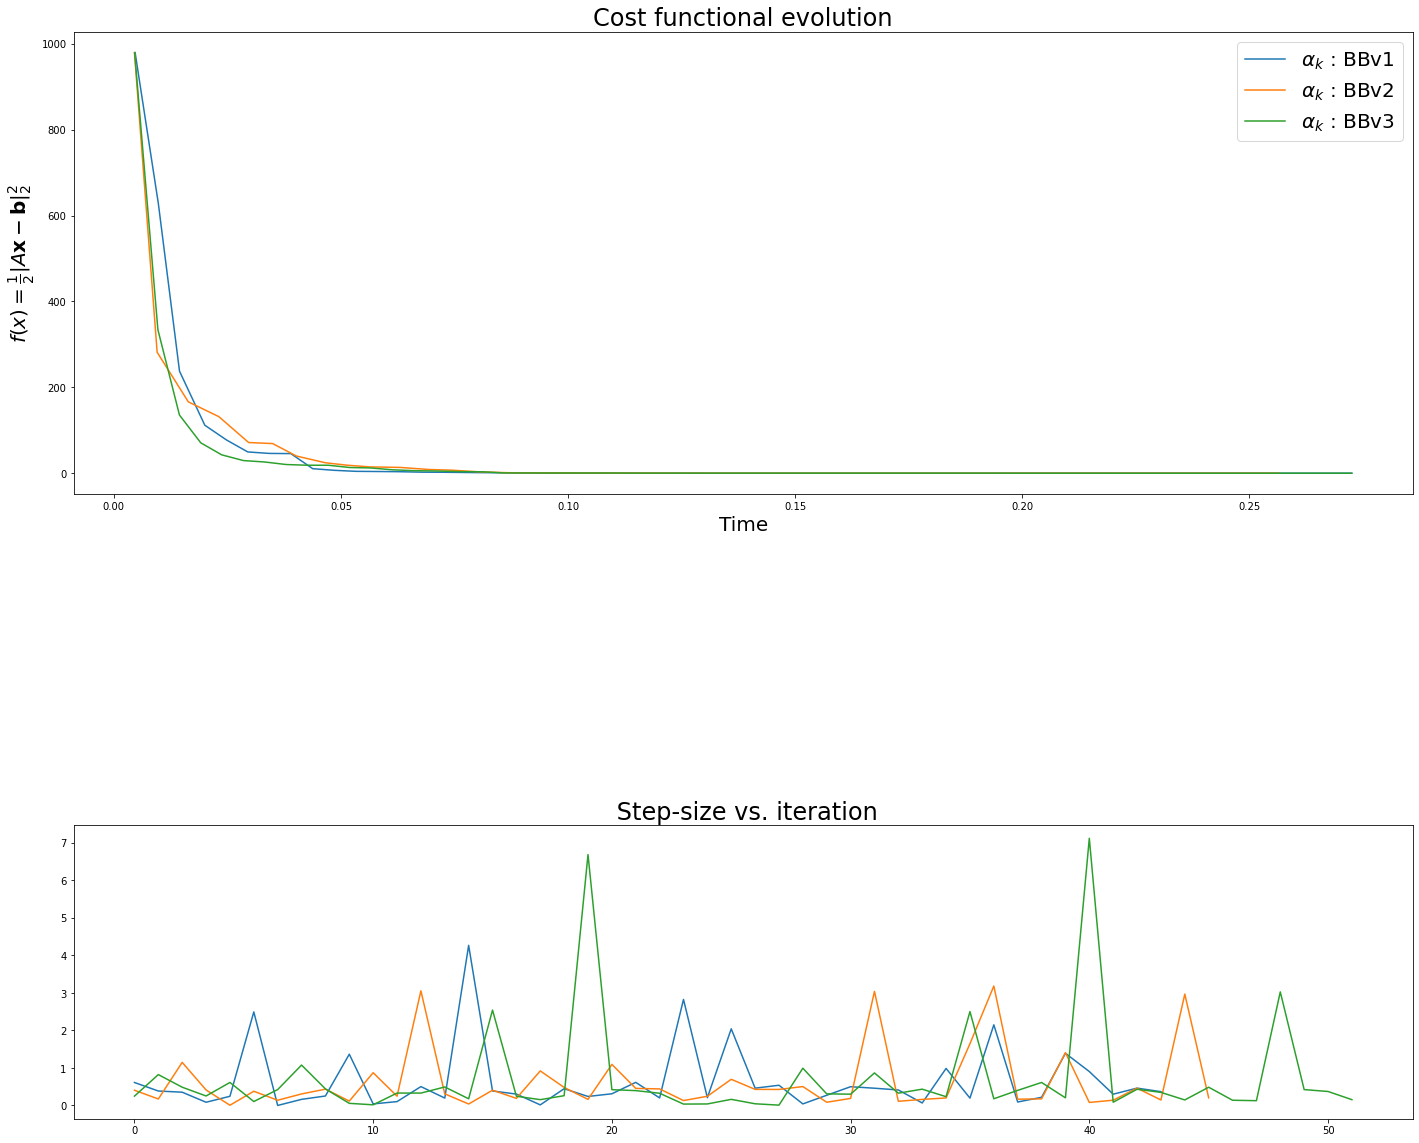

In [20]:
fig = PLT.figure(figsize=(24, 20))

ax1 = fig.add_subplot(2, 1, 1)


for n in np.arange(1,len(ssPol)):
    PLT.plot(Stats[n][:,2], Stats[n][:,0], label=r'$\alpha_k$ : {0}'.format(ssPol[n].name) )

PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2}\| A \mathbf{x} - \mathbf{b} \|_2^2$',fontsize=20)
PLT.xlabel('Time',fontsize=20)
PLT.title('Cost functional evolution',fontsize=24)
PLT.subplots_adjust(hspace = 0.35)


ax1 = fig.add_subplot(3, 1, 3)
for n in np.arange(1,len(ssPol)):
    PLT.plot(Stats[n][:,1], label=r'$\alpha_k$ : {0}'.format( ssPol[k].name ) )

PLT.title('\n Step-size vs. iteration',fontsize=24)